In [ ]:
import pydot
import matplotlib.pyplot as plt
import time
import math
#import networkx as nx
#import random

# Step 1

## Uploading the data

In [ ]:
def get_data(dot_file_path):
     #= 'Datasets/LesMiserables.dot'
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    name= str(list(edges[0].get_attributes().keys())[0])
    weights = {(edge.get_source(), edge.get_destination()):float(edge.get_attributes()[name]) for edge in edges}

    return nodes,edges,node_list,edge_list,weights
#ans = get_data('Datasets/LesMiserables.dot')
#nodes,edges,node_list,edge_list,weights = get_data('Datasets/LesMiserables.dot')
#print(('1','40') in edge_list)
# print(len(node_list)**3) #nodes
# print(len(edge_list))
# print(len(edge_list)*len(node_list)) #edges
# print()
# Nodes:  77 
#Edges:  254
#Total:  33982

## Tree Layout

### Counting the number of children/parents for each node

In [ ]:
#COUNTING THE NUMBER OF CHILD NODES FOR EACH NODE
def f_childs(file_name_name):   
    nodes = get_data(file_name_name)[0]
    edges = get_data(file_name_name)[1]
    node_child_count = {node.get_name(): 0 for node in nodes}
    node_childs = {node.get_name(): [] for node in nodes}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        if source in node_child_count:
            node_child_count[source] += 1 
            node_childs[source].append(destination) #comment
    return node_child_count, node_childs

#Count
#print(f_childs('Datasets/LesMiserables.dot')[0])
#print(sum(list(f_childs('Datasets/LesMiserables.dot')[0].values())))
#child_11,child_25,child_26 = f_childs('Datasets/LesMiserables.dot')[1]['11'],f_childs('Datasets/LesMiserables.dot')[1]['25'],f_childs('Datasets/LesMiserables.dot')[1]['26']
#print('CHILD')
#print('11: ',child_11)
#print('25: ',child_25)
#print('26": ',child_26)

#List      
#print(f_childs('Datasets/LesMiserables.dot')[1])

def f_parents(file_name_name):
    nodes = get_data(file_name_name)[0]
    edges = get_data(file_name_name)[1]
    node_parent_count = {node.get_name(): 0 for node in nodes}
    node_parents = {node.get_name(): [] for node in nodes}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        if destination in node_parent_count:
            node_parent_count[destination] += 1 
            node_parents[destination].append(source)
    return node_parent_count, node_parents

#Count
#print(f_parents('Datasets/LesMiserables.dot')[0]['11'])
#parent_27 = f_parents('Datasets/LesMiserables.dot')[1]['27']
#print("PARENT")
#print('27: ', parent_27)
#List      
#print(f_parents('Datasets/LesMiserables.dot')[1])

def f_edges(file_name):
    nodes = get_data(file_name)[0]
    edges = get_data(file_name)[1]
    node_edges_count = {node.get_name(): 0 for node in nodes}
    node_edges = {node.get_name(): [] for node in nodes}
    
    parents = f_parents(file_name)[1]
    childs = f_childs(file_name)[1]

    for node,l_parents in parents.items():
        for parent in l_parents:
            node_edges_count[node] +=1
            node_edges[node].append(parent)
    
    for node,l_childs in childs.items():
        for child in l_childs:
            node_edges_count[node] +=1
            node_edges[node].append(child)
    return node_edges_count,node_edges

#print(f_edges('Datasets/LesMiserables.dot')[1])
#print(f_parents('Datasets/LesMiserables.dot')[1])

#edges = f_edges('Datasets/LesMiserables.dot')
#parents = f_parents('Datasets/LesMiserables.dot')

#print(edges == parents)
#print(edges[0])

### Organizing the nodes throughout the graph, getting their coordinates for the tree layout

In [ ]:
def tree_layout(file):
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    #lonely_nodes_y = -4
    
    for edge in edges:
        n+=1
        l_m = []
        m=0
        #print(edge)#.get_source())
    #    print(node_childs[str(edge.get_destination())])
        parent_x = node_positions[str(edge.get_source())][0]
        parent_y = node_positions[str(edge.get_source())][1]
        step = 3#random.choice([2,3])

        #nnodes with only one child
        if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            #print(edge)
            #random.choice([2,3])
            child_x = parent_x + step
            child_y = parent_y
            node_positions[edge.get_destination()] = (child_x, child_y)
            done_nodes.append(int(edge.get_destination()))
        
        #nodes with more than one node
        elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
            if len(node_childs[str(edge.get_source())])%2 != 0:
                max_y = (node_child_count[str(edge.get_source())]-1)*3
            else:
                max_y = (node_child_count[str(edge.get_source())]-1)*3+1
            for child in node_childs[str(edge.get_source())]:
                m+=1
                child_x = parent_x + step
                child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                max_y -=8
                done_nodes.append(int(edge.get_destination()))
            l_m.append(m)
            total += m
        total+=n
        #elif len(node_childs[str(edge.get_source())]) == 0 and len(node_childs[str(edge.get_destination())]) == 0:
        #    node_positions[child]

        #elif len([done_node for done_node in done_nodes if done_node == edge.get_destination()])==1:
        #    child_x += 1               
        
    return node_positions,n,l_m,total

#pos,n,m,total = tree_layout('Datasets/LesMiserables.dot')
#print("Edges: ",n, '\n',"Nodes: ",m, '\n',"Total: ",total,)
#f_childs(nodes,edges)[1]['17']

### Improved version of the Tree layout

Get the nodes that have the same parent and are directly connected to each other

In [ ]:
def common_parents(file_name):
    nodes,edges,node_list,edge_list,weights = get_data(file_name)
    ans = {node:[] for node in node_list}
    count = {node:0 for node in node_list}
    for edge1 in edges:
        for edge2 in edges:
            if edge1.get_source() == edge2.get_source() and edge1.get_destination() != edge2.get_destination() and (str(edge1.get_destination()),str(edge2.get_destination())) in edge_list:# and str(edge1.get_destination()) not in ans:
                #ans.append((str(edge1.get_destination()),str(edge2.get_destination())))
                #ans[edge1.get_source()] = []
                ans[edge1.get_source()].append((str(edge1.get_destination()),str(edge2.get_destination())))
   
    for node,edges in ans.items():
        for edge in edges:
            #print(edge)
            count[edge[1]] += 1
    return count

#common_parents('Datasets/LesMiserables.dot')

In [ ]:
def tree_layout_improv(file):
    #returns the coordinates for each node 
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    
    for edge in edges:
        parent_x = node_positions[str(edge.get_source())][0]
        parent_y = node_positions[str(edge.get_source())][1]
        
        #weights
        position = str(str(edge.get_attributes())).rfind(':')
        if int(position) != -1:
            w = int(str(edge.get_attributes())[position+3:-2])
            if w != 1:
                w = w/10

        #nodes with only one child
        if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            #print(edge)
            step = 3#random.choice([2,3])
            child_x = parent_x + step
            child_y = parent_y
            node_positions[edge.get_destination()] = (child_x, child_y)
            done_nodes.append(int(edge.get_destination()))
            print()
        
        #nodes with more than one node
        elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
            if len(node_childs[str(edge.get_source())])%2 != 0:
                max_y = (node_child_count[str(edge.get_source())]-1)*3
            else:
                max_y = (node_child_count[str(edge.get_source())]-1)*3+1
            for child in node_childs[str(edge.get_source())]:
                step = 3#random.choice([2,3])
                child_x = parent_x + step
                child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                max_y -=8
                done_nodes.append(int(edge.get_destination()))
        #elif len([done_node for done_node in done_nodes if done_node == edge.get_destination()])==1:
        #    child_x += 1
                
    #correcting the child_x in cases where sibling nodes are connected to each other
    for node,count in [(node,count) for node,count in common_parents(file).items() if count != 0]:
        node_positions[node] = (node_positions[node][0]+count/3,node_positions[node][1])
    
    return node_positions

#tree_layout_improv('Datasets/LesMiserables.dot')

### Time complexity of the improved version

In [ ]:
 # Record the start time

# Code to execute the algorithm
# For example:
def time_complexity(file,layout,ite):
    ans = []
    for i in range(ite):
        if layout == 'tree_layout':
            start_time = time.time() 
            result = tree_layout(file)
            end_time = time.time() 
        
        if layout == 'tree_layout_improv':
            start_time = time.time() 
            result = tree_layout_improv(file)
            end_time = time.time() 
         # Record the end time
        elapsed_time = end_time - start_time  # Calculate the elapsed time
        ans.append(elapsed_time)
    print('In average, the layout',layout, 'takes', round(sum(ans)/len(ans), 2),'seconds to implement on the', file,'dataset.') 

#time_complexity('Datasets/LesMiserables.dot','tree_layout_improv',10)

### Plot the graph

In [ ]:
#HOW TO PLOT A GENERAL GRAPH
def show_graph(file,layout,dims):
    if layout == 'tree_layout':
        node_positions = tree_layout(file)
        
    if layout == 'tree_layout_improv':
        node_positions = tree_layout_improv(file)

    if layout == 'BFS_tree':
        node_positions = BFS_tree(file)

    nodes,edges = get_data(file)[0],get_data(file)[1]
    plt.figure(figsize=(dims[0], dims[1]))

    for edge in edges:
        start_node = edge.get_source()
        end_node = edge.get_destination()
        start_pos = node_positions[start_node]
        end_pos = node_positions[end_node]

        position = str(str(edge.get_attributes())).rfind(':')
        if int(position) != -1:
            w = int(str(edge.get_attributes())[position+3:-2])
            if w != 1:
                w = w/10
        #else:
        #    w=1
        #plt.scatter([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], color='black', s=10, linewidths=w)
        plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
    plt.axis('off')
    plt.gca().set_facecolor('w')
    plt.savefig(layout+'plot.png')
    plt.show()
    
#show_graph('Datasets/LesMiserables.dot','tree_layout1',(18,18))
#show_graph('Datasets/LesMiserables.dot','tree_layout_improv',(18,18))

### Bonus Task

In [ ]:
#HOW TO CREATE THE DEFAULT LAYOUT
def bonus_task(file,layout):
    with open(file, 'r') as dot_file:
        dot_data = dot_file.read()

    # Create a graph object from the .dot data
    graph = pydot.graph_from_dot_data(dot_data)

    # Set the layout algorithm to "dot" (or any other supported layout type)
    graph[0].set_graph_defaults(layout=layout)
    graph[0].set_graph_defaults(layout=layout,)
    # Render the graph with Graphviz
    output_file_path = layout+'.png'
    graph[0].write_png(output_file_path)


#for layout in ["dot", "neato", "circo", "fdp", "twopi"]:
#    bonus_task('Datasets/LesMiserables.dot',layout)
#bonus_task('Datasets/LesMiserables.dot',"twopi")
#print("Graph with dot layout saved as:", output_file_path)


# Step 2

### Constructing a BFS tree

In [ ]:
def BFS_tree(file,plot = 'No'):
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes = set()
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    tree = {node.get_name(): [] for node in nodes}
    #lonely_nodes_y = -4
    min_y = 0

    for node in nodes:#node_childs[str(node)]:
        
        done_nodes.add(str(node.get_name()))
        childs = node_childs[str(node.get_name())]
        parent_x = node_positions[str(node.get_name())][0]
        parent_y = node_positions[str(node.get_name())][1]
        step = 3

        #print('Number of childs: ',len(node_childs[str(node.get_name())]))
        #print('node: ',str(node.get_name()))
        if len(node_childs[str(node.get_name())]) == 1 and str(node_childs[str(node.get_name())][0]) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            #print('child: ',str(node_childs[str(node.get_name())][0]))
            #random.choice([2,3])
            child_x = parent_x + step
            # if parent_y > min_y:
            #     child_y = min_y-6
            # else:
            child_y = parent_y
            node_positions[str(node_childs[str(node.get_name())][0])] = (child_x, child_y)
            done_nodes.add(str(node_childs[str(node.get_name())][0]))
            tree[node.get_name()].append(str(node_childs[str(node.get_name())][0]))
            #min_y = child_y

        elif len(node_childs[str(node.get_name())]) >1:# and node_childs[str(node.get_name())] not in done_nodes:
            #if len(node_childs[str(node.get_name())])%2 != 0:
            
            #else:
            #    max_y = (node_child_count[str(node.get_name())]-1)*3+1
            #print('node: ',node.get_name(),'parent_y: ', parent_y)
            new_childs = len([child for child in node_childs[str(node.get_name())] if child not in done_nodes])
            max_y = (new_childs-1)*3
            #print('node: ',node.get_name(),'node_position: ',node_positions[node.get_name()],'max_y',max_y)
            
            done_childs = []
            for child in [new_child for new_child in node_childs[str(node.get_name())] if new_child not in done_nodes]:
                done_childs.append(child)
                #if str(child) not in done_nodes:
                child_x = parent_x + step
                # if parent_y + max_y > min_y:
                #     child_y = min_y-6+max_y
                # else:
                child_y = parent_y + max_y
                
                #child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                done_nodes.add(str(child))
                max_y -= 6
                tree[node.get_name()].append(str(child))
            if len(done_childs)>0:
                min_y = node_positions[done_childs[-1]][1]
            #print(done_childs)
            #min_y = node_positions[[child for child in node_childs[str(node.get_name())] if child not in done_nodes][-1]]
            #print('min_y from the childs of node', node,':',min_y)
        #print(min_y) 
        #print('node: ',node,'node position: ', node_positions[node.get_name()],'done nodes: ',done_nodes) 
        
    if plot != 'No':
        plt.figure(figsize=(18, 18))

        reached_dests = set()
        for edge in edges:
            #print('source: ',node_positions[str(edge.get_source())],'dest: ', node_positions[str(edge.get_destination())])
            if node_positions[str(edge.get_source())][0] != node_positions[str(edge.get_destination())][0] and str(edge.get_destination()) not in reached_dests:
                start_node = edge.get_source()
                end_node = edge.get_destination()
                start_pos = node_positions[start_node]
                end_pos = node_positions[end_node]

                position = str(str(edge.get_attributes())).rfind(':')
                if int(position) != -1:
                    w = int(str(edge.get_attributes())[position+3:-2])
                    if w != 1:
                        w = w/10
            #else:
            #    w=1
            #plt.scatter([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], color='black', s=10, linewidths=w)
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 
            reached_dests.add(str(edge.get_destination()))
        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        plt.axis('off')
        plt.gca().set_facecolor('w')
        plt.savefig('BFS_tree_plot.png')
        plt.show()
    final_tree = {i:j for i,j in tree.items() if j!= []}
    return node_positions,final_tree

#write_ordered_dic('Datasets/LesMiserables.dot')
#tree = BFS_tree('example.dot')[1]
#tree = BFS_tree('Datasets/LesMiserables.dot')

#tree = BFS_tree('new_file.dot')
#show_graph('Datasets/LesMiserables.dot','BFS_tree',(18,18))
# #print("Edges: ",n, '\n',"Nodes: ",m, '\n',"Total: ",total,)
# #f_childs(nodes,edges)[1]['17']

# Radial Layout

### Sorting the nodes based on their degree

In [ ]:
def f_edges(file_name):
    nodes = get_data(file_name)[0]
    edges = get_data(file_name)[1]
    node_edges_count = {node.get_name(): 0 for node in nodes}
    node_edges = {node.get_name(): [] for node in nodes}
    
    parents = f_parents(file_name)[1]
    childs = f_childs(file_name)[1]

    for node,l_parents in parents.items():
        for parent in l_parents:
            node_edges_count[node] +=1
            node_edges[node].append(parent)
    
    for node,l_childs in childs.items():
        for child in l_childs:
            node_edges_count[node] +=1
            node_edges[node].append(child)
    return node_edges_count,node_edges

#final_edges = f_edges('Datasets/LesMiserables.dot')[1]

In [ ]:
def sort_nodes_degree(file):
    return dict(sorted(f_edges(file)[1].items(), key=lambda item: len(item[1]), reverse=True))

# dic = sort_nodes_degree('Datasets/LesMiserables.dot')
# dic

In [ ]:
def write_ordered_dic(file,new_file):
    dic = sort_nodes_degree(file)
    nodes_list = get_data(file)[2]
    edge_list = get_data(file)[3]
    weigths = get_data(file)[4]
    done_nodes = set()

    graph = pydot.Dot(graph_type='graph')

    # for node_ish in nodes_list:
    #     node = pydot.Node(node_ish)
    #     graph.add_node(node)
    
    for node_ish,childs in dic.items():
        node = pydot.Node(node_ish)
        if node_ish not in done_nodes:
            graph.add_node(node)
            done_nodes.add(node_ish)
        for child_ish in childs:
            child = pydot.Node(child_ish)
            if child_ish not in done_nodes:
                graph.add_node(child)
                done_nodes.add(child_ish)
            #graph.add_node(child)
            edge_ish = (str(node_ish), str(child_ish) )
            if edge_ish not in edge_list:
                edge_ish = (str(child_ish), str(node_ish))
            w = int(weigths[edge_ish])
            edge = pydot.Edge(str(node_ish), str(child_ish), weight=w)
            graph.add_edge(edge)
    
    graph.write(new_file)

#write_ordered_dic('Datasets/LesMiserables.dot','example.dot')

In [ ]:
def get_key(dictionary, value):
     return next((key for key, val in dictionary.items() if value in val), None)


In [ ]:
def count_descendants(tree, node_name):
    if node_name not in tree:
        return 0
    
    descendants = 0
    if node_name in tree:
        children = tree[node_name]
        descendants += len(children)  # Add the direct children count
        for child in children:
            descendants += count_descendants(tree, child)
    return descendants

def count_ancestors(tree, node_name):
    ancestors = 0
    nodes = tree
    key = get_key(tree,node_name)
    #print('key',key)
    if key != None:
        parent = get_key(tree,node_name)
        ancestors += 1           
        ancestors += count_ancestors(tree, parent)
    return ancestors


In [ ]:
def depth(file):
    tree = BFS_tree(file)[0] 
    pass

def f_layers(file):
    tree = BFS_tree(file)[0]
    layers = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for node, pos in tree.items():
        layer = int(pos[0]/3)
        layers[layer].append(node)
    return layers

#print(f_layers('example.dot'))

In [ ]:
def radial(file,ordered = False):
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    #radius = 3
    root = list(tree.keys())[0]
    layers = f_layers(file)
    angle = 0
    starting_angle=0
    for subtree in tree:
        root = subtree
        for node in tree[root]:
            for i in layers:
                if node in i:
                    layer = layers.index(i)
            #print(layer)
            radius = 3*layer

            parent_x = node_positions[node][0]
            parent_y = node_positions[node][1]
            
            descendants = count_descendants(tree, node)
            if descendants >0:
                childs = tree[node]
                increment = 2*math.pi*(descendants+1)/count_descendants(tree, root)
            else:
                increment = 2*math.pi/count_descendants(tree, root)
            #print(subtree,':',angle)
            if radius >3:
                acos = math.acos(parent_x/radius)
                asin = math.asin(parent_x/radius)
                if parent_y >0:
                    starting_angle = math.acos(parent_x/radius)
                elif parent_y <0:
                    starting_angle = math.pi+math.acos(parent_x/radius)
            
            
            if root in ['11','2']:
                angle+= increment/2-starting_angle
                child_x = math.cos(angle)*radius
                child_y = math.sin(angle)*radius
                angle+= increment/2
                node_positions[node]=(child_x,child_y)
   
    return node_positions


#write_ordered_dic('Datasets/LesMiserables.dot','example.dot')
#ans1 = radial('example.dot')

In [ ]:
#import matplotlib.pyplot as plt
def f_plot(file):
    ans = hugo_radial(file)
    x_coords = [coord[0] for coord in ans.values()]
    y_coords = [coord[1] for coord in ans.values()]

    plt.figure(figsize=(15, 15))
    plt.scatter(x_coords, y_coords, color='red')

    # Add labels for each point
    for point, coord in ans.items():
        plt.text(coord[0], coord[1], f' {point}', fontsize=12, ha='right')
    
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot of Points')
    plt.grid(True)
    plt.show()

#f_plot('example.dot')

In [ ]:
def hugo_radial(file,ordered = False):
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    #radius = 3
    root = list(tree.keys())[0]
    layers = f_layers(file)
    angle = 0
    green=0
    for subtree in tree:
        #root = subtree
        for node in tree[subtree]:
            for i in layers:
                if node in i:
                    layer = layers.index(i)
            #print(layer)
            radius = 3*layer

            parent_x = node_positions[node][0]
            parent_y = node_positions[node][1]
            
            descendants = count_descendants(tree, subtree)
            if layer <= 1: 
                if descendants >0:
                    childs = tree[node]
                    increment = 2*math.pi*(descendants+1)/count_descendants(tree, root)
                else:
                    increment = 2*math.pi/count_descendants(tree, root)
            #print(subtree,':',angle)
            if layer > 1:
                
                acos = math.acos(parent_x/radius)
                asin = math.asin(parent_x/radius)
                
                
                red = 2*math.pi*(1+count_descendants(tree, node))/count_descendants(tree, subtree)
                
                #print('root node:',root,'node: ',node,'red angle',red)
                if parent_y >0:
                    green = math.acos(parent_x/radius)-red/2
                elif parent_y <0:
                    #vermelho = 2*math.pi/count_descendants(tree, root)
                    green = math.pi+math.acos(parent_x/radius)-red/2
                
                if descendants >0:
                    childs = tree[node]
                    increment = red/(count_descendants(tree, subtree)+2)
                else:
                    increment = red/(count_descendants(tree, subtree)+2)
            
            #print(green)
            #if root in ['11','24']:
            angle+= green+increment/2
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius
            angle+= increment/2
            node_positions[node]=(child_x,child_y)
   
    return node_positions


#write_ordered_dic('Datasets/LesMiserables.dot')
#ans2 = hugo_radial('example.dot')
#hugo_radial('example.dot')

In [ ]:
ans2 = hugo_radial('example.dot')

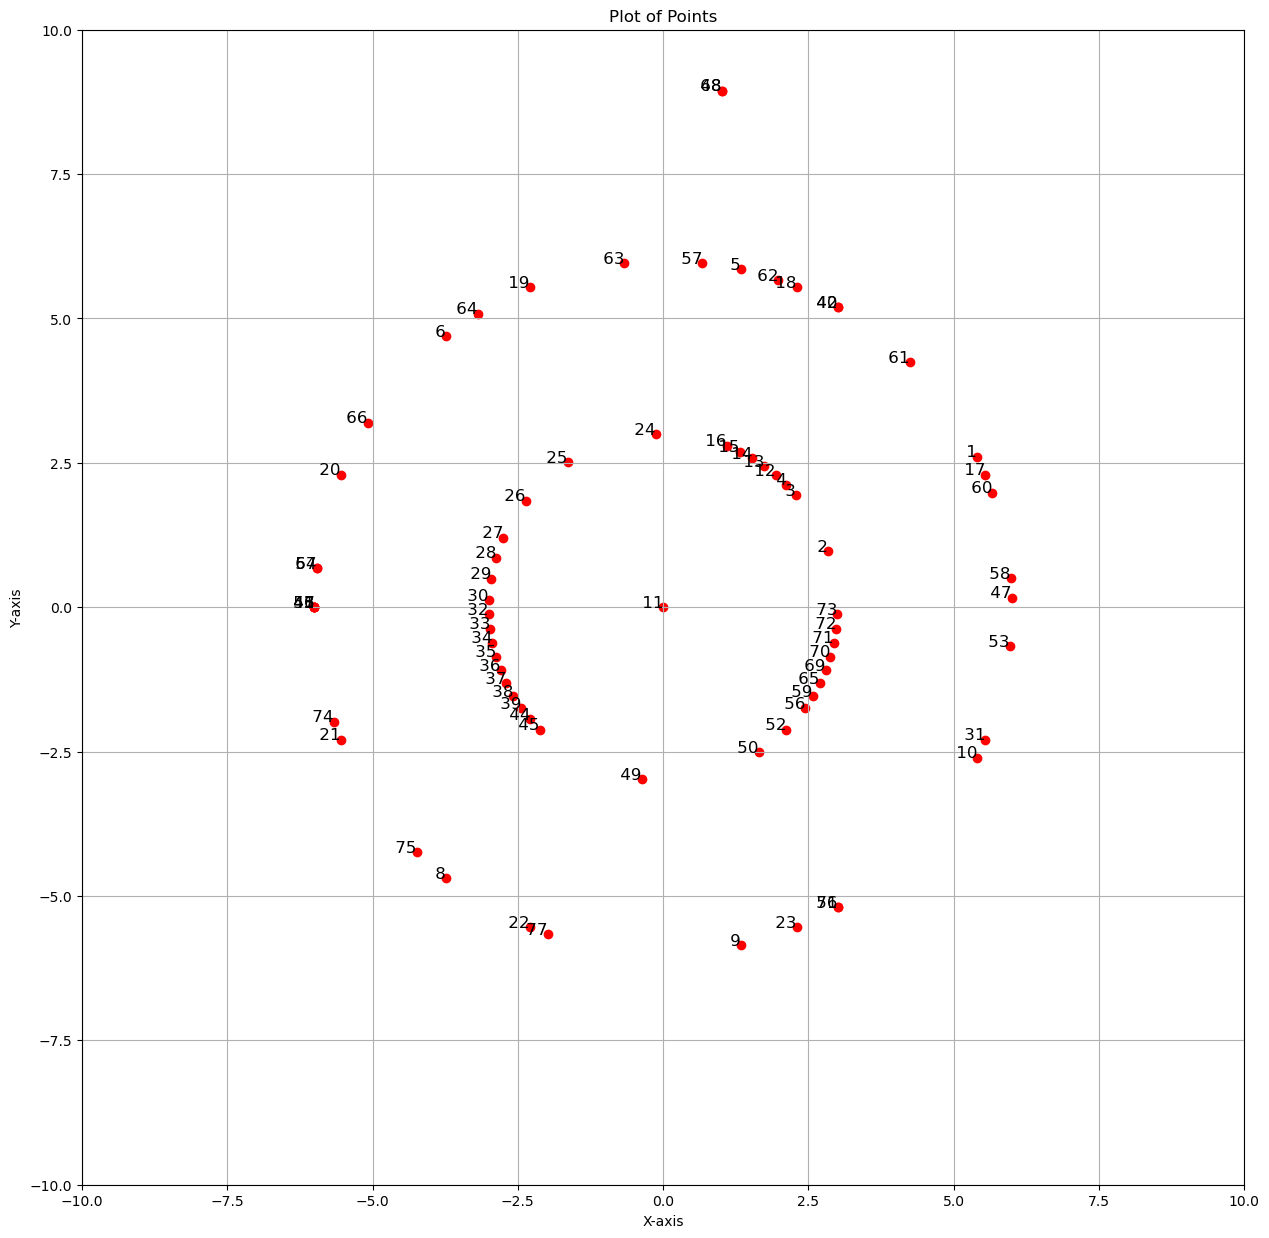

In [44]:
f_plot('example.dot')

In [ ]:
tree = BFS_tree('example.dot')[1]

In [ ]:
for subtree in tree:
        root = subtree
        for node in tree[root]:
            print('root: ', root, 'node: ',node)
            #print('node: ',node)

In [ ]:
def new_radial(file,ordered = False):
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    radius = 3
    root = list(tree.keys())[0]

    
    layers = f_layers(file)
    for layer in layers[1:]:
        angle = 0
        for node in layer:
            descendants = count_descendants(tree[node], node)
            if descendants >0:
                childs = tree[node]
                increment = 2*math.pi*(descendants+1)/count_descendants(tree, subtree)
            else:
                increment = 2*math.pi/count_descendants(tree, subtree)
                #print(node,':',angle)

            angle+= increment/2
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius
            angle+= increment/2
            node_positions[node]=(child_x,child_y)
        radius += 3

    # angle = 0
    # for subtree in tree:
    #     for node in subtree:
    #         descendants = count_descendants(tree, node)
    #         if descendants >0:
    #             childs = tree[node]
    #             increment = 2*math.pi*(descendants+1)/count_descendants(tree, subtree)
    #         else:
    #             increment = 2*math.pi/count_descendants(tree, subtree)
    #             #print(node,':',angle)

    #         angle+= increment/2
    #         child_x = math.cos(angle)*radius
    #         child_y = math.sin(angle)*radius
    #         angle+= increment/2
    #         node_positions[node]=(child_x,child_y)
    #     radius += 3
    return node_positions


#ans = new_radial('example.dot')

In [ ]:
math.acos(-3/3)

# TRASH

In [ ]:
def tree(file):#,starting_point):
    graph = get_data(file)
    nodes_ish = graph[0]
    nodes = sorted([int(node.get_name()) for node in nodes_ish])
    #print(nodes)
    edges = graph[1]
    #root = starting_point
    links = f_edges(file)[1]

    tree = {node: [] for node in nodes}
    done_nodes = []
    for child in childs:
        tree[root].append(child)
        done_nodes.add(child)
    #print('root', root,'childs: ', childs)
    # print('done nodes: ',done_nodes)        
    # print('#######')
    while len(done_nodes)!=len(nodes):
        for child1 in childs:
            root = child1
            print('root', root,'childs: ', childs)
            #if root not in done_nodes:
            done_nodes.add(root)
            new_childs = [child2 for child2 in links[root] if child2 not in done_nodes]
            #print('root', root,'childs: ', new_childs)
            if len(new_childs)==1 and new_childs[0] not in done_nodes:
                tree[child1].append(new_childs[0])
                done_nodes.add(new_childs[0])
            
            elif len(new_childs)>1:# and new_childs[0] not in done_nodes:
                for child2 in new_childs:
                    if child2 not in done_nodes:
                        tree[child1].append(child2)
                        done_nodes.add(child2)
        
            # print('done nodes: ',done_nodes)        
            # print('#################')
        yet_to_do_nodes = [node for node in nodes if node not in done_nodes]
        #yet_to_do_nodes = [set(graph[2])-done_nodes]
        root = sorted(list(yet_to_do_nodes))[0]
        done_nodes.add(root)
        childs = links[root]
        #print('root', root,'childs: ', childs)
        #print('#######')
    return tree

#ans = tree('Datasets/LesMiserables.dot')#,'1')
#print(ans)



### Trash-ish for radial layout

In [ ]:
#new_file = write_ordered_dic('Datasets/LesMiserables.dot')

def radial1(file,ordered = False):
    # total = 0
    # n=0
    # graph = get_data(file)
    # nodes = graph[0]
    # edges = graph[1]
    # node_positions = {node.get_name(): (0, 0) for node in nodes}
    # done_nodes= []
    # node_child_count = f_childs(file)[0]
    # node_childs = f_childs(file)[1]
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    radius = 3
    angle = 360/3
    for node in tree:
        childs = tree[str(node)]
        #print('node: ', node, 'childs: ', childs)
        parent_x = node_positions[node][0]
        parent_x = node_positions[node][1]
        increment = 360/len(childs)
        num_childs = len(childs)
        angle = 0
        for child in childs:
            angle += increment
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius

            node_positions[child]=(child_x,child_y)
            
        radius += 2
    return node_positions

ans = radial('example.dot')

# General Code

In [ ]:
print(edges.get_values())
#for node in nodes:
 #   print("Node name:", node.get_name())
  #  print("Node label:", node.get_label())
   # print("Node attributes:", node.get_attributes())
    #print("Node shape:", node.get_shape())
    #print("Node style:", node.get_style())
    #print("Node position:", node.get_pos())
    
    
#for edge in edges:
 #   print("Source:", edge.get_source())
  #  print("Destination:", edge.get_destination())
    #print("Edge attributes:", edge.get_attributes())
    #position = str(str(edge.get_attributes())).rfind(':')
    #w = str(edge.get_attributes())[position+3:-2]
    #print(w)
    #print("Edge style:", edge.get_style())
    #print("Edge label:", edge.get_label())
    #print("Edge color:", edge.get_color())

# TRASH